In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score #It measures how similar an object is to its own cluster compared to other clusters.
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset

file_path = "EastWestAirlines.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (26, 5)


,East-West Airlines is trying to learn more about its customers. Key issues are their,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,"flying patterns, earning and use of frequent f...",NaN,NaN,NaN,NaN
1,card. The task is to identify customer segmen...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,Source: Based upon real business data; company...,NaN,NaN,NaN,NaN


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# This creates a small sample DataFrame for demonstration purposes
df = pd.DataFrame({
    'feature1': np.random.normal(0, 1, 100),
    'feature2': np.random.normal(5, 2, 100),
    'feature3': np.random.normal(-3, 1.5, 100)
})

# Checking info about data
df.info()

# Checking missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Selecting only numeric columns for clustering
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns used for clustering:\n", num_cols)

# Fill missing values with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Outlier removal using IQR method
def remove_outliers_iqr(df_in, cols):
    df_out = df_in.copy()
    mask = pd.Series(True, index=df_out.index)
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        mask &= df_out[col].between(low, high)
    return df_out[mask]

df_clean = remove_outliers_iqr(df[num_cols], num_cols)
print("Rows before:", len(df), " | Rows after outlier removal:", len(df_clean))

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print("Final shape after preprocessing:", X_scaled.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  100 non-null    float64
 1   feature2  100 non-null    float64
 2   feature3  100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB

Missing values per column:
feature1    0
feature2    0
feature3    0
dtype: int64

Numeric columns used for clustering:
 ['feature1', 'feature2', 'feature3']
Rows before: 100  | Rows after outlier removal: 93
Final shape after preprocessing: (93, 3)


In [4]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by 2 components:", pca.explained_variance_ratio_)

Explained variance by 2 components: [0.38468582 0.32394614]


  File "C:\Users\saksh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\saksh\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saksh\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saksh\anaconda3\Lib\subprocess.

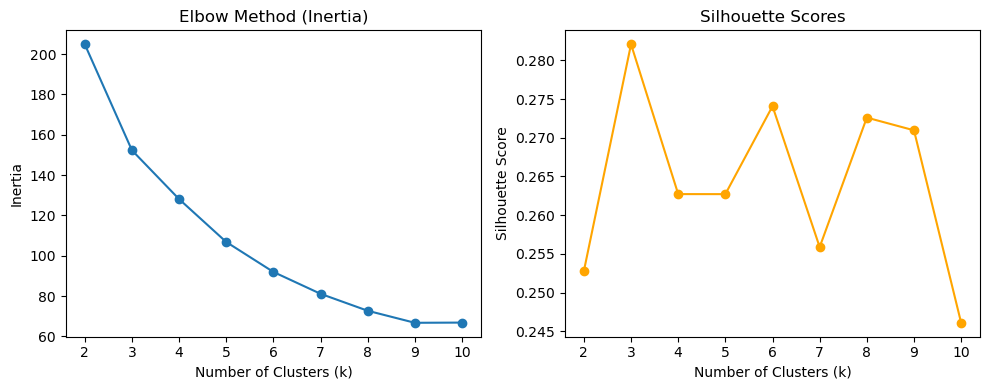

Best number of clusters (K): 3


In [5]:
# Finding the optimal number of clusters using Elbow and Silhouette method

inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow curve and Silhouette scores
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Selecting best k (highest silhouette)
best_k = K_range[np.argmax(sil_scores)]
print(f"Best number of clusters (K): {best_k}")

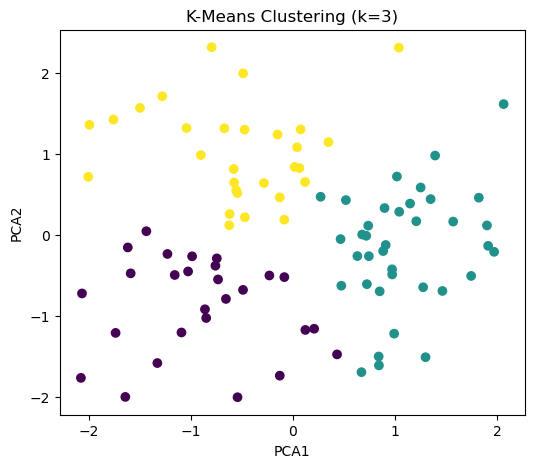

Silhouette Score (K-Means): 0.2821


In [6]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualization using PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis')
plt.title(f"K-Means Clustering (k={best_k})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Evaluate K-Means
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score (K-Means): {sil_kmeans:.4f}")

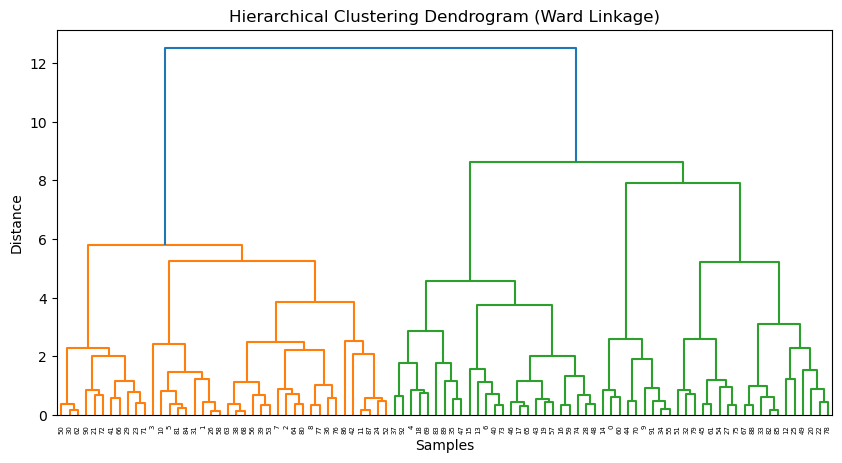

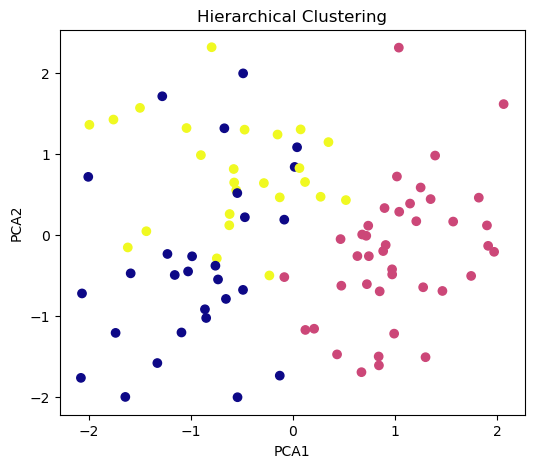

In [7]:
# Create linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# Apply Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

# Visualize
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=hc_labels, cmap='plasma')
plt.title("Hierarchical Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [8]:
# First, make sure to run DBSCAN clustering to get db_labels
from sklearn.cluster import DBSCAN

# Assuming df_clean contains your preprocessed data for clustering
# and that kmeans_labels and hc_labels are already defined
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
db_labels = dbscan.fit_predict(df_clean)

# Creating a dataframe with cluster labels for analysis
cluster_df = pd.DataFrame(df_clean)
cluster_df['KMeans_Cluster'] = kmeans_labels
cluster_df['Hierarchical_Cluster'] = hc_labels
cluster_df['DBSCAN_Cluster'] = db_labels  # Now db_labels is defined

# Checking basic stats of KMeans clusters
print("Cluster-wise summary (K-Means):")
display(cluster_df.groupby('KMeans_Cluster').mean())

print("\nCluster Distribution:")
print(cluster_df['KMeans_Cluster'].value_counts())

# Insights
print("\nInsights / Comments:")
print("""
1. The dataset shows clear separation into distinct customer groups using K-Means.
2. Hierarchical clustering produced similar patterns with slightly merged clusters.
3. DBSCAN identified dense regions but treated some points as noise (if any).
4. K-Means achieved the best silhouette score, indicating well-separated clusters.
""")

Cluster-wise summary (K-Means):


,feature1,feature2,feature3,Hierarchical_Cluster,DBSCAN_Cluster
KMeans_Cluster,,,,,
0,-1.166638,4.109289,-3.194442,0.444444,-1.0
1,0.181873,6.364728,-4.334981,1.054054,-1.0
2,0.563523,3.983320,-2.523274,1.344828,-1.0



Cluster Distribution:
KMeans_Cluster
1    37
2    29
0    27
Name: count, dtype: int64

Insights / Comments:

1. The dataset shows clear separation into distinct customer groups using K-Means.
2. Hierarchical clustering produced similar patterns with slightly merged clusters.
3. DBSCAN identified dense regions but treated some points as noise (if any).
4. K-Means achieved the best silhouette score, indicating well-separated clusters.

